# Fixed and smooth effects in location reg

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os 

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

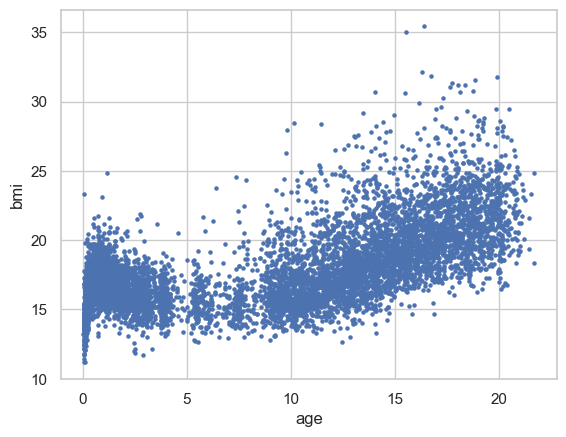

In [2]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [3]:
# Define a model with intercept 
# Set up design matrix 
X = tiger.Obs(name="X_loc", intercept=True)
X.smooth(data=df["age"].to_numpy())
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
X.center()

# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_fixed_loc = tiger.Hyper(0.0, name="beta_fixed_loc")
beta_fixed_scale = tiger.Hyper(100.0, name="beta_fixed_scale")

# Set up parameters
beta_fixed_dist = tiger.Dist(tfjd.Normal, loc=beta_fixed_loc, scale=beta_fixed_scale)
beta_fixed = tiger.Param(value=df["bmi"].to_numpy().mean(), distribution=beta_fixed_dist, name="beta_fixed")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
tau_a = tiger.Hyper(1.0, name="tau_a")
tau_b = tiger.Hyper(0.00005, name="tau_b")
tau_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=jnp.array([1.0]), distribution=tau_dist, param_space="positive", name="tau")

# Smooth coefficients
# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
beta_smooth_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="beta_smooth_loc")

# Define the penalty matrix 
pen = X.smooth_pen_mat_cent[0]

# Set up parameters
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, scale=tau, pen=pen)
beta_smooth = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=beta_smooth_dist, name="beta_smooth")
# ----

# Set up the linear predictor
lpred = tiger.Lpred(obs=X, beta_fixed=beta_fixed, beta_smooth=beta_smooth)

# Set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

## Test log-prob and setup the graph 

In [4]:
m.log_prob

Array(-23843.072, dtype=float32)

In [5]:
m.log_prior

Array(-37.034946, dtype=float32)

In [6]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [7]:
graph.logprob()

Array(-23843.072, dtype=float32)

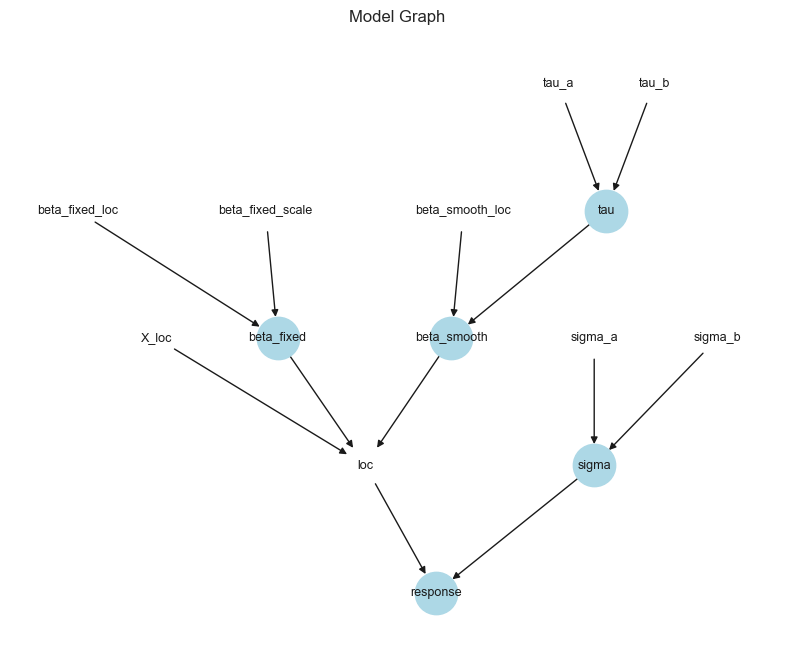

In [8]:
graph.visualize_graph()

## Test functions of Bbvi

In [9]:
import tigerpy.distributions.mvn as mvn
q = bbvi.Bbvi(graph=graph)
key = jax.random.PRNGKey(27)
key, *subkeys = jax.random.split(key, len(q.init_variational_params)+1)

AttributeError: 'Bbvi' object has no attribute 'init_variational_params'

In [10]:
loc_beta_fixed, lower_tri_beta_fixed = q.init_variational_params["beta_fixed"]["loc"], q.init_variational_params["beta_fixed"]["lower_tri"]
loc_beta_smooth, lower_tri_beta_smooth = q.init_variational_params["beta_smooth"]["loc"], q.init_variational_params["beta_smooth"]["lower_tri"]
loc_sigma, lower_tri_sigma = q.init_variational_params["sigma"]["loc"], q.init_variational_params["sigma"]["lower_tri"]
loc_tau, lower_tri_tau= q.init_variational_params["tau"]["loc"], q.init_variational_params["tau"]["lower_tri"]

In [11]:
samples_beta_fixed = mvn.mvn_precision_chol_sample(loc=loc_beta_fixed, precision_matrix_chol=lower_tri_beta_fixed, key=subkeys[0], S=64)
samples_beta_smooth = mvn.mvn_precision_chol_sample(loc=loc_beta_smooth, precision_matrix_chol=lower_tri_beta_smooth, key=subkeys[1], S=64)
samples_sigma = mvn.mvn_precision_chol_sample(loc=loc_sigma, precision_matrix_chol=lower_tri_sigma, key=subkeys[2], S=64)
samples_tau = mvn.mvn_precision_chol_sample(loc=loc_tau, precision_matrix_chol=lower_tri_tau, key=subkeys[3], S=64)

In [12]:
test_samples = {"beta_fixed": samples_beta_fixed,
                "beta_smooth": samples_beta_smooth,
                "sigma": jnp.exp(samples_sigma),
                "tau": jnp.exp(samples_tau)}

In [19]:
batch_idx = jax.random.choice(key, q.num_obs, (32,), replace=False)

In [20]:
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [21]:
q.mc_logprob(data_new,  test_samples, q.num_obs)

Array(-24635.795, dtype=float32)

In [22]:
q.lower_bound(q.init_variational_params, 
              data_new,
              num_obs=q.num_obs,
              num_var_samples=64,
              key=key)

Array(24217.83, dtype=float32)

## Inference with Bbvi

In [32]:
q = bbvi.Bbvi(graph=graph)

In [34]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=1,
           batch_size=1024,
           num_var_samples=64,
           chunk_size=50,
           epochs=500)

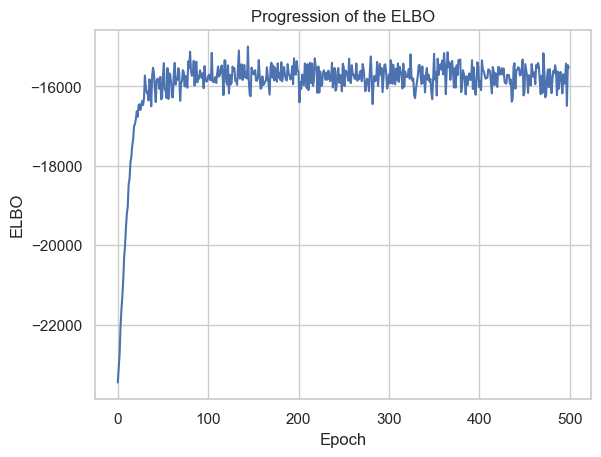

In [35]:
q.plot_elbo()

## Visualize the regression line 

In [36]:
b = q.trans_var_params["beta_smooth"]["loc"]
b

Array([-2.612212  , -2.5986116 , -2.0624967 , -2.2421196 , -2.3799074 ,
       -2.1180415 , -1.7018286 , -1.4038808 , -1.1640847 , -0.6142881 ,
       -0.09629548,  0.45820308,  1.1236728 ,  1.5573728 ,  2.1413813 ,
        2.8432705 ,  3.3109279 ,  3.6549902 ,  3.91126   ], dtype=float32)

In [37]:
# for fixed and smooth terms
b_fixed = q.trans_var_params["beta_fixed"]["loc"]
b_smooth = q.trans_var_params["beta_smooth"]["loc"]
b = jnp.concatenate((b_fixed, b_smooth))
y = X.design_matrix @ b

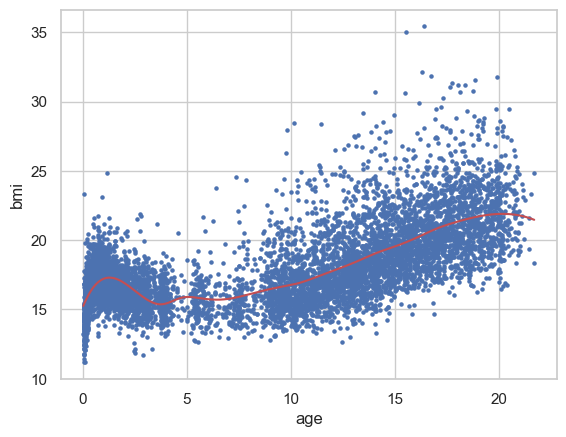

In [38]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(df["age"].to_numpy(), y, color = "r")
plt.show()

In [28]:
tau = q.trans_var_params["tau"]["loc"]
s = q.trans_var_params["tau"]["cov"]

In [29]:
tau, s

(Array([-0.46442372], dtype=float32), Array([[0.02623332]], dtype=float32))

In [30]:
m = jnp.exp(tau + s/2)

In [31]:
1 / (m ** 2)

Array([[2.4660413]], dtype=float32)